# Yelp Sentiment EDA
266 Summer 2024
Kevin Kuc, 

The data is publically available here:
*   https://huggingface.co/datasets/Yelp/yelp_review_full


**Data Dictionary**

1.   'text': The review texts are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".
2.   'label': Corresponds to the score associated with the review (between 1 and 5).

## Step 1: Import packages

In [23]:
import pandas as pd
import numpy as np
import csv
import copy
from datasets import load_dataset

# data preprocessing
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA
from numpy.random.mtrand import binomial
import random
import string
from nltk.corpus import stopwords
from contractions import fix

# exploratory analysis
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import seaborn as sns
from IPython.display import Image
from textblob import TextBlob
from wordcloud import WordCloud

# model fit
import statsmodels.api as sm
#import tensorflow as tf
#from tensorflow import keras
#from keras import metrics
#from tensorflow.keras import initializers


# ignore warnings (libraries are rapidly changing)
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# These commands below set some options for pandas and to have matplotlib show the charts in the notebook
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None  # default='warn'

## Step 2: Read data

In [24]:
dataset = load_dataset('yelp_review_full')
df = dataset['train'].to_pandas()
# print shape of df
print(
    'Shape of data: ',
    df.shape
)

Shape of data:  (650000, 2)


In [25]:
df.head(10)

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...
5,4,Top notch doctor in a top notch practice. Can'...
6,4,Dr. Eric Goldberg is a fantastic doctor who ha...
7,0,I'm writing this review to give you a heads up...
8,1,Wing sauce is like water. Pretty much a lot of...
9,2,Decent range somewhat close to the city. The ...


In [26]:
df['text'][0]

"dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."

In [27]:
# Randomly sample 50,000 entries
sampled_df = df.sample(n=50000, random_state=42)

In [28]:
# Check null values
print(sampled_df.isnull().sum().sort_values(ascending = False)) # Check nulls

print(sampled_df["label"].value_counts())

label    0
text     0
dtype: int64
label
3    10131
2    10095
0    10049
1     9966
4     9759
Name: count, dtype: int64


## Step 3: Data preprocessing


#### Step 3.1: Preprocess Text

In [29]:
def preprocess_review(review):
    """Ensures the input is a string, converts it to lovercase, removes puncuation, 
    keeps alphabetical words only, remove any whitespaces"""
    if isinstance(review, list):
        review = ' '.join(review)
    review = review.lower()
    review = ''.join([char for char in review if char not in string.punctuation])
    review = ' '.join([word for word in review.split() if word.isalpha()])
    review = ' '.join(review.split())
    return review

sampled_df['text'] = sampled_df['text'].apply(preprocess_review)

#### Step 3.2: Create Multiclass outcome variable

In [30]:
## define outcome variable with 0 being negative, 1 being mixed, and 2 being positive and ##
#############################

rating_dict = {0: 0, 1: 0, 2: 1, 3: 2, 4: 2}
multi_df = copy.deepcopy(sampled_df)
multi_df["label"] = multi_df.label.map(rating_dict)
multi_df["label"].value_counts().sort_index()

label
0    20015
1    10095
2    19890
Name: count, dtype: int64

##### Step 3.2.1: Undersample the Majority Class to match the Mixed Class

In [31]:
df_negative_class = multi_df[multi_df['label'] == 0]
df_mixed_class = multi_df[multi_df['label'] == 1]
df_positive_class = multi_df[multi_df['label'] == 2]


# Resample the negative and positive class to match mixed class
df_negative_class_downsampled = resample(df_negative_class,
                                  replace=False,
                                  n_samples=len(df_mixed_class),
                                  random_state=1)

df_positive_class_downsampled = resample(df_positive_class,
                                  replace=False,
                                  n_samples=len(df_mixed_class),
                                  random_state=1)

# Combine all classes
multi_df_balanced = pd.concat([df_negative_class_downsampled, df_mixed_class, df_positive_class_downsampled])

# Shuffle the dataset
multi_df_balanced = multi_df_balanced.sample(frac=1).reset_index(drop=True)

#check the balanced dataset
multi_df_balanced["label"].value_counts().sort_index()

label
0    10095
1    10095
2    10095
Name: count, dtype: int64

In [32]:
multi_df_balanced['text']

0        i got chased away by a very rude manager as th...
1        well the single sign on yelp and the star rati...
2        literally the worst restaurant experience that...
3        the staff is very friendly here plenty of suit...
4        do you like carrot top i mean do you really li...
                               ...                        
30280    w t freakazoid for the price it is not with it...
30281    not gross but nothing struck me as amazing her...
30282    okay i have lived in phoenix and in la i have ...
30283    ive been with most of the big banks and i cant...
30284    clean rooms hot water quiet but i did not like...
Name: text, Length: 30285, dtype: object

#### Step 3.3: Create Binary outcome variable

In [33]:
## define outcome variable with 0 being negative and 1 being positive##
#############################
binary_sampled_df = copy.deepcopy(sampled_df)
binary_sampled_df = binary_sampled_df[binary_sampled_df['label'] != 2]
rating_dict = {0: 0, 1: 0, 3: 2, 4: 2}

binary_sampled_df["label"] = binary_sampled_df.label.map(rating_dict)
binary_sampled_df["label"].value_counts().sort_index()

label
0    20015
2    19890
Name: count, dtype: int64

#### Step 3.4: All stars outcome variable

In [34]:
## Include all stars##
#############################
all_df = copy.deepcopy(sampled_df)
all_df["label"].value_counts().sort_index()

label
0    10049
1     9966
2    10095
3    10131
4     9759
Name: count, dtype: int64

## Step 4: EDA

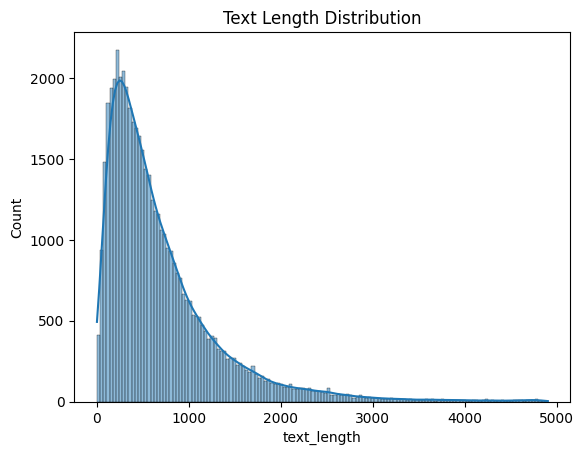

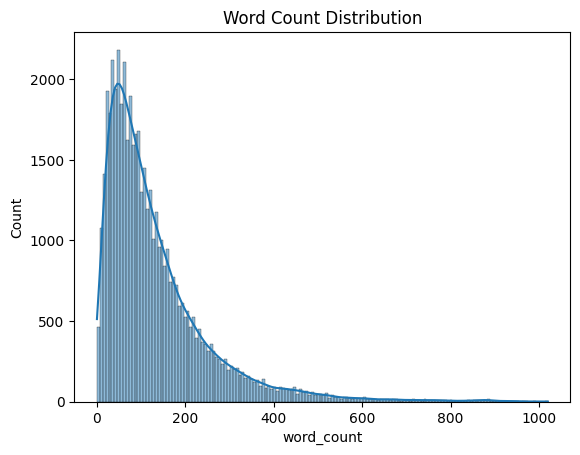

In [35]:
#Analyze text length and word count
all_df['text_length'] = all_df['text'].apply(len)
all_df['word_count'] = all_df['text'].apply(lambda x: len(x.split()))

sns.histplot(all_df['text_length'], kde=True)
plt.title('Text Length Distribution')
plt.show()

sns.histplot(all_df['word_count'], kde=True)
plt.title('Word Count Distribution')
plt.show()

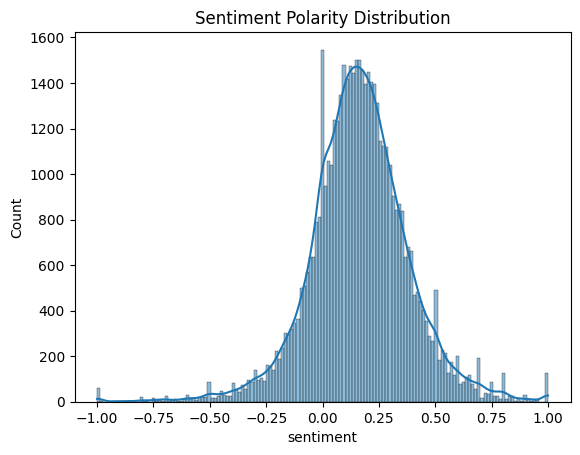

In [36]:
all_df['sentiment'] = all_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
sns.histplot(all_df['sentiment'], kde=True)
plt.title('Sentiment Polarity Distribution')
plt.show()